Episode: 100 Total reward:  -5000.0 Running reward: -4369
Episode: 200 Total reward:  -5000.0 Running reward: -3012
Episode: 300 Total reward:  -424.0 Running reward: -616
Episode: 400 Total reward:  -312.0 Running reward: -339
Episode: 500 Total reward:  -200.0 Running reward: -269
Episode: 600 Total reward:  -180.0 Running reward: -214
Episode: 700 Total reward:  -166.0 Running reward: -179
Episode: 800 Total reward:  -123.0 Running reward: -162
Episode: 900 Total reward:  -208.0 Running reward: -156
Episode: 1000 Total reward:  -155.0 Running reward: -147
Episode: 1100 Total reward:  -118.0 Running reward: -146
Episode: 1200 Total reward:  -191.0 Running reward: -162
Episode: 1300 Total reward:  -193.0 Running reward: -175
Episode: 1400 Total reward:  -116.0 Running reward: -203
Episode: 1500 Total reward:  -141.0 Running reward: -158
Episode: 1600 Total reward:  -145.0 Running reward: -156
Episode: 1700 Total reward:  -120.0 Running reward: -172
Episode: 1800 Total reward:  -122.0 

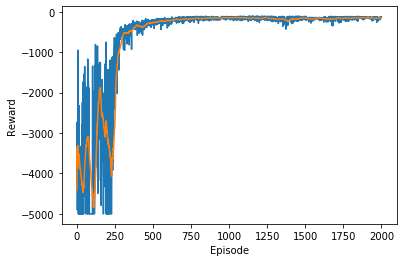

In [17]:
""" This code is inspired by https://github.com/nikhilbarhate99/PPO-PyTorch/blob/master/PPO.py"""
import torch
import torch.nn as nn
from torch.distributions import Categorical
import gym
import matplotlib.pyplot as plt

# avoid the warning message
gym.logger.set_level(40)

class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(ActorCritic, self).__init__()

        # actor
        self.action_layer = nn.Sequential(
                nn.Linear(state_dim, hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim, action_dim),
                nn.Softmax(dim=-1)
                )
        
        # critic
        self.value_layer = nn.Sequential(
                nn.Linear(state_dim, hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim, 1)
                )
        
    def forward(self):
        raise NotImplementedError
        
    def act(self, state, memory):
        state = torch.from_numpy(state).float()
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        
        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))
        
        return action.item()
    
    def evaluate(self, state, action):
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy() # """entropy: """
        
        state_value = self.value_layer(state)
        
        return action_logprobs, torch.squeeze(state_value), dist_entropy
        
class PPO:
    def __init__(self, state_dim, action_dim, hidden_dim, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.policy = ActorCritic(state_dim, action_dim, hidden_dim)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        self.policy_old = ActorCritic(state_dim, action_dim, hidden_dim)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def update(self, memory):   
        # Monte Carlo estimate of state rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)#  """insert: """
        
        # Normalizing the rewards:
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        # convert list to tensor
        old_states = torch.stack(memory.states).detach() # """torch.stack: """
        old_actions = torch.stack(memory.actions).detach()
        old_logprobs = torch.stack(memory.logprobs).detach()
        
        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values :
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            
            # Finding the ratio (pi_theta / pi_theta__old):
            ratios = torch.exp(logprobs - old_logprobs.detach())
                
            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        
        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())
        
def main():
    ############## Hyperparameters ##############
    # creating environment
    env = gym.make("MountainCar-v0")
    env = env.unwrapped
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    max_episodes = 2000        # max training episodes
    max_timesteps = 5000         # max timesteps in one episode
    hidden_dim = 64           # number of variables in hidden layer
    update_timestep = 1000      # update policy every n timesteps
    lr = 0.002
    betas = (0.9, 0.999)
    gamma = 0.99                # discount factor
    K_epochs = 4                # update policy for K epochs
    eps_clip = 0.2              # clip parameter for PPO
    #############################################
    

    torch.manual_seed(1)
    env.seed(1)
    
    memory = Memory()
    ppo = PPO(state_dim, action_dim, hidden_dim, lr, betas, gamma, K_epochs, eps_clip)
    
    # logging variables
    timestep = 0
    ep_rewards =[]
    running_rewards=[]
   
    # training loop
    for i_episode in range(1, max_episodes+1):
        state = env.reset()
        
        # logging variables
        ep_reward = 0
        
        for t in range(max_timesteps):
            timestep += 1
            
            # Running policy_old:
            action = ppo.policy_old.act(state, memory)
            state, reward, done, _ = env.step(action)
            
            # Saving reward and is_terminal:
            memory.rewards.append(reward)
            memory.is_terminals.append(done)
            
            # update if its time
            if timestep % update_timestep == 0:
                ppo.update(memory)
                memory.clear_memory()
                timestep = 0
            
            ep_reward += reward

            # show performance 
            if i_episode == max_episodes:
                env.render()

            if done:
                break
                            
        # logging
        ep_rewards.append(ep_reward)
        running_rewards.append(torch.mean(torch.Tensor(ep_rewards[-30:])))
        
        if i_episode % 100 == 0:
            print('Episode:', i_episode, 'Total reward: ', ep_reward, 'Running reward:', int(running_rewards[-1]))
            
    plt.plot(ep_rewards)
    plt.plot(running_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show() 
            
if __name__ == '__main__':
    main()
    